In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 5e-7 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse
theta = 0.5 # fraction hillslope that enters as coarse
# treat as same!!! Point is what fraction becomes coarse
# so just be sure to change these together

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma, theta,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 50
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * gamma
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * theta)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1] - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 2000000

test_run = [x, dx, x_node, 
            K, beta, gamma, theta,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

100000000.0


In [7]:
Eb

array([1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
      

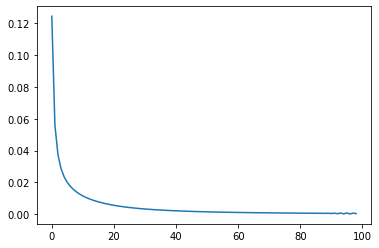

In [8]:
plt.plot(S)

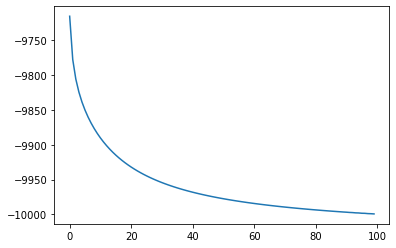

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.00043863578082164166

In [11]:
eta

array([-9715.43376854, -9777.66656113, -9805.7368429 , -9824.35699656,
       -9838.63152073, -9850.35755172, -9860.36816451, -9869.12073675,
       -9876.89691976, -9883.88505893, -9890.21907649, -9895.99875828,
       -9901.30120272, -9906.18770403, -9910.70811272, -9914.90372205,
       -9918.80925201, -9922.45425765, -9925.86415732, -9929.0610019 ,
       -9932.0640628 , -9934.8902897 , -9937.55467303, -9940.07053504,
       -9942.44976649, -9944.70302147, -9946.83987912, -9948.86897929,
       -9950.79813706, -9952.63444023, -9954.38433269, -9956.05368629,
       -9957.647863  , -9959.17176892, -9960.62990149, -9962.02639083,
       -9963.36503613, -9964.64933773, -9965.88252557, -9967.06758442,
       -9968.2072763 , -9969.30416056, -9970.3606118 , -9971.37883588,
       -9972.36088445, -9973.30866785, -9974.22396685, -9975.10844324,
       -9975.96364939, -9976.79103692, -9977.59196457, -9978.36770538,
       -9979.11945319, -9979.84832857, -9980.55538424, -9981.24161007,
      

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([283.96623133, 221.73343874, 193.66315697, 175.0430033 ,
       160.76847913, 149.04244815, 139.03183535, 130.27926312,
       122.50308011, 115.51494094, 109.18092338, 103.40124158,
        98.09879715,  93.21229583,  88.69188715,  84.49627782,
        80.59074786,  76.94574222,  73.53584255,  70.33899796,
        67.33593707,  64.50971017,  61.84532683,  59.32946483,
        56.95023338,  54.6969784 ,  52.56012075,  50.53102058,
        48.6018628 ,  46.76555964,  45.01566718,  43.34631358,
        41.75213687,  40.22823095,  38.77009837,  37.37360903,
        36.03496374,  34.75066214,  33.51747429,  32.33241545,
        31.19272357,  30.0958393 ,  29.03938807,  28.02116398,
        27.03911541,  26.09133202,  25.17603301,  24.29155662,
        23.43635048,  22.60896295,  21.8080353 ,  21.03229448,
        20.28054667,  19.5516713 ,  18.84461562,  18.1583898 ,
        17.49206233,  16.84475592,  16.21564363,  15.60394546,
        15.00892502,  14.42988668,  13.86617276,  13.31